# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: Марнаутов Николай Александрович

Группа: MADE-DS-12

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
import matplotlib.pyplot as plt
import folium
from openrouteservice import client
import osmapi as osm
from OSMPythonTools.api import Api
from OSMPythonTools.overpass import Overpass
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

In [2]:
os.chdir(r"C:\Users\ML\YandexDisk\0000 MADE\Geo\HW2\Data")
os.getcwd()

'C:\\Users\\ML\\YandexDisk\\0000 MADE\\Geo\\HW2\\Data'

In [3]:
api_key = '5b3ce3597851110001cf6248545ca6b6dfa3428e8cec1f2e1905a796' 
clnt = client.Client(key=api_key) 

In [4]:
api_osm = osm.OsmApi()

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

In [5]:
from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()
areaId = nominatim.query('Afganistan').areaId()

In [6]:
areaId

3600303427

In [7]:
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
overpass = Overpass()
query = overpassQueryBuilder(area=areaId, elementType=['way', 'relation'], selector=[' "admin_level"="2"  ', ' "boundary"="administrative"  '], includeGeometry=True)
result = overpass.query(query, timeout=600)

In [8]:
firstElement = result.elements()[0]
firstElement.geometry()
afgan = gpd.GeoDataFrame(firstElement.geometry())

In [9]:
data_afg_load = gpd.GeoDataFrame(firstElement.geometry())

In [10]:
afg_poly_norm = [[y, x] for x, y in list(data_afg_load["coordinates"][0])]

In [11]:
map_params = {'location':[36.879803, 73.892046],
              'zoom_start': 2}
map_hw1 = folium.Map(**map_params)
map_hw1.add_child(folium.LatLngPopup())

folium.vector_layers.Polygon(
    locations=afg_poly_norm,
    color='#ffd699',
    fill_color='#ffd699',
    fill_opacity=0.2,
    weight=3
).add_to(map_hw1)

In [12]:
map_hw1

In [13]:
afg_polygon = Polygon(data_afg_load["coordinates"][0])

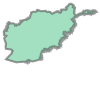

In [14]:
afg_polygon

In [15]:

def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return (earth_radius * 2 * np.arcsin(np.sqrt(a)))

In [16]:
np.random.seed(10)

In [17]:
def generator_lat_lon(lat_min, lat_max, lon_min, lon_max):
    lat = np.random.uniform(lat_min, lat_max)
    lon = np.random.uniform(lon_min, lon_max)
    return lat, lon

def check_in(p_in, poly):
    p = Point(list(reversed(p_in)))
    return p.within(poly)

In [18]:
"""
Алгоритм: 
Генерирую случайную точку, 
затем разбиваю плоскость на 4 части и смотрю, куда попадает центра Афганистанга.
Выбираю ту четверть, в которую попал центр Афганистана, все повторяется рекурсивно

P.S. Только сейчас дошло, что это наверное и есть наивный алгоритм поиска. 
Переделать не успеваю т.к. уже дедлайн(
"""
def finder_afg(lat_min, lat_max, lon_min, lon_max, poly):
    
    middle_point = [poly.centroid.y, poly.centroid.x]
    
    lat_min = lat_min
    lat_max = lat_max
    lon_min = lon_min
    lon_max = lon_max
    
    lat, lon = generator_lat_lon(lat_min, lat_max, lon_min, lon_max)

    if check_in([lat, lon], poly):
        folium.Marker(
        location = [lat, lon],
        icon=folium.Icon(color = "red"),
        ).add_to(map_hw1)
        
        print(lat, lon)
        return lat, lon
    
    folium.Marker(
        location = [lat, lon]
    ).add_to(map_hw1)
        
    qaurter_1 = Polygon([[lon_min, lat_min], [lon, lat_min], [lon, lat], [lon_min, lat]])
    qaurter_2 = Polygon([[lon, lat_min], [lon_max, lat_min], [lon_max, lat], [lon, lat]])
    qaurter_3 = Polygon([[lon_min, lat], [lon, lat], [lon, lat_max], [lon_min, lat_max]])
    qaurter_4 = Polygon([[lon, lat], [lon_max, lat], [lon_max, lat_max], [lon, lat_max]])
    if check_in(middle_point, qaurter_1):     

        lat_max = lat
        lon_max = lon
        
        folium.vector_layers.Rectangle(
        bounds=[[lat_min, lon_min], [lat_max, lon_max]],
        color='#FF0000',
        fill_color='#ffd699',
        fill_opacity=0.3,
        weight=3
        ).add_to(map_hw1)
        
        finder_afg(lat_min, lat_max, lon_min, lon_max, poly)
        
    elif check_in(middle_point, qaurter_2):                
 
        lat_max = lat
        lon_min = lon
        
        folium.vector_layers.Rectangle(
        bounds=[[lat_min, lon_min], [lat_max, lon_max]],
        color='#FF0000',
        fill_color='#ffd699',
        fill_opacity=0.3,
        weight=3
        ).add_to(map_hw1)
        
        finder_afg(lat_min, lat_max, lon_min, lon_max, poly)    
    elif check_in(middle_point, qaurter_3):
 
        lat_min = lat
        lon_max = lon
        
        folium.vector_layers.Rectangle(
        bounds=[[lat_min, lon_min], [lat_max, lon_max]],
        color='#FF0000',
        fill_color='#ffd699',
        fill_opacity=0.3,
        weight=3
        ).add_to(map_hw1)
        
        finder_afg(lat_min, lat_max, lon_min, lon_max, poly)
    else:        
 
        lat_min = lat
        lon_min = lon
        
        folium.vector_layers.Rectangle(
        bounds=[[lat_min, lon_min], [lat_max, lon_max]],
        color='#FF0000',
        fill_color='#ffd699',
        fill_opacity=0.3,
        weight=3
        ).add_to(map_hw1)
        
        finder_afg(lat_min, lat_max, lon_min, lon_max, poly)
    
 

In [19]:
print(finder_afg(lat_min = -90, lat_max = 90, lon_min = -180, lon_max = 180, poly=afg_polygon))

31.88742136773084 68.58688359920636
None


In [20]:
map_hw1

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [21]:
# put your code here

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [22]:
# put your code here
school_data = gpd.read_file(r"C:\Users\ML\YandexDisk\0000 MADE\Geo\HW2\Data\2019_-_2020_School_Point_Locations.csv")


In [23]:
def make_lat(row):
    lat = list(map(float, row["the_geom"].strip(")").split("(")[1].split()))[1]
    return lat

def make_long(row):
    long = list(map(float, row["the_geom"].strip(")").split("(")[1].split()))[0]
    return long

def make_school_point(row):
    out = Point(row["lat"], row["long"])
    return out

def make_reversed_school_point(row):
    out = Point(row["long"], row["lat"])
    return out

def make_avoid_polygon(row):
    out = row["school_point"].buffer(0.001, resolution=2)
    return out

def make_reversed_avoid_polygon(row):
    out = row["reversed_school_point"].buffer(0.001, resolution=2)
    return out

In [24]:
school_data["lat"] = school_data.apply(make_lat, axis=1)
school_data["long"] = school_data.apply(make_long, axis=1)

In [25]:
school_data["school_point"] = school_data.apply(make_school_point, axis=1)
school_data["reversed_school_point"] = school_data.apply(make_reversed_school_point, axis=1)

In [26]:
school_data["avoid_polygon"] = school_data.apply(make_avoid_polygon, axis=1)
school_data["reversed_avoid_polygon"] = school_data.apply(make_reversed_avoid_polygon, axis=1)

In [27]:
school_data = school_data[school_data["lat"] > 35]
school_data = school_data.reset_index()

In [28]:
school_data["geometry"] = school_data["reversed_avoid_polygon"]

In [29]:
"""
fig, ax = plt.subplots(figsize=(20, 20))
school_data.plot(ax=ax)
plt.show()
"""

'\nfig, ax = plt.subplots(figsize=(20, 20))\nschool_data.plot(ax=ax)\nplt.show()\n'

In [30]:
def style_function(color):
    return lambda feature: dict(color=color,
                              weight=3,
                              opacity=0.5)

In [31]:
point_central_park = [40.7802, -73.9614]
point_water_washington = [40.7032, -73.9896]



In [32]:
map_params = {'location':point_central_park,
              'zoom_start': 13}
map_hw3 = folium.Map(**map_params)

folium.Marker(
    location = point_central_park,
    icon=folium.Icon(icon='glyphicon-user')
).add_to(map_hw3)

folium.Marker(
    location = point_water_washington,
    icon=folium.Icon(icon='glyphicon-user')
).add_to(map_hw3)

map_hw3.add_child(folium.LatLngPopup())

In [33]:
coordinates = [list(reversed(point_central_park)), list(reversed(point_water_washington))]

In [34]:

direction_params_1 = {'coordinates': coordinates,
                    'profile': 'driving-car', 
                    'format_out': 'geojson',
                    'preference': 'shortest',
                    'geometry': 'true'}


route_normal = clnt.directions(**direction_params_1) 

folium.features.GeoJson(data=route_normal,
                        name='Normal route', 
                        style_function=style_function('#FF0000'),
                        overlay=True).add_to(map_hw3)

In [35]:
direction_params_2 = {'coordinates': coordinates,
                      'options': {'avoid_polygons': geometry.mapping(MultiPolygon(list(school_data["reversed_avoid_polygon"])))},
                    'profile': 'driving-car', 
                    'format_out': 'geojson',
                    'preference': 'shortest',
                    'geometry': 'true'}

route_detour = clnt.directions(**direction_params_2) 

folium.features.GeoJson(data=route_detour,
                        name='Avoid schools', 
                        style_function=style_function('#00FF00'),
                        overlay=True).add_to(map_hw3)


In [36]:
route_buffer_normal = LineString(route_normal['features'][0]['geometry']['coordinates']).buffer(0.009)
route_buffer_detour = LineString(route_detour['features'][0]['geometry']['coordinates']).buffer(0.009)

In [37]:

for i in range(school_data.shape[0]):
    school = school_data["reversed_school_point"][i]
    if route_buffer_normal.intersects(school) or route_buffer_detour.intersects(school):
        
        
        folium.CircleMarker(
            location=[school_data["school_point"][i].x, school_data["school_point"][i].y],
            radius=1,
            color='red',
        ).add_to(map_hw3)
        
        folium.vector_layers.Polygon(
            locations=list(school_data["avoid_polygon"][i].exterior.coords),
            color='#ffd699',
            fill_color='#ffd699',
            fill_opacity=0.3,
            weight=3
        ).add_to(map_hw3)


### Красным отмечен кратчайший возможный маршрут, без учета школ
### Зеленым отмечен маршрут в объезд школ

In [38]:
map_hw3

In [39]:
map_hw3